<a href="https://colab.research.google.com/github/Atkiya/CSE475_ML/blob/main/Lab/Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

**Purpose of each libaray:**

pandas for data manipulation and analysis.

numpy for numerical computing

matplotlib for data visualization

seaborn for high-level statistical data visualization built on top of Matplotlib.

StandardScaler for feature scaling

KMeans for partitioning data into K clusters, minimizing within-cluster variance.

DBSCAN for density-based clustering and to find clusters of high density and labels sparse points as noise.

GaussianMixture for probabilistic clustering

PCA for dimentionality reduction

silhouette_score to measure how well points fit their assigned cluster vs other clusters (range -1 to 1).

davies_bouldin_score to measure average similarity between clusters (lower is better).

# Loading the Dataset

In [2]:
!gdown --id 1Q6pdhzWFu2oegWMPvrOE8dWTra8FJsTf

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:139: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Q6pdhzWFu2oegWMPvrOE8dWTra8FJsTf
To: /content/Mall_Customers.csv
100% 3.98k/3.98k [00:00<00:00, 12.1MB/s]


In [3]:
df =  pd.read_csv("/content/Mall_Customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
df.info()
df.isnull().any()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


,0
CustomerID,False
Gender,False
Age,False
Annual Income (k$),False
Spending Score (1-100),False


No null values were found

# Praparing the dataset

In [5]:
df = df.drop(columns=["CustomerID"])

Removing CustomerID because it is an identifier and does not contribute to clustering.

In [6]:
df = pd.get_dummies(df, columns=["Gender"], drop_first=True)

In [7]:
df

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
0,19,15,39,True
1,21,15,81,True
2,20,16,6,False
3,23,16,77,False
4,31,17,40,False
...,...,...,...,...
195,35,120,79,False
196,45,126,28,False
197,32,126,74,True
198,32,137,18,True


Applying one-hot encoding because clustering algorithms used here requires numeric input.
They only work with numbers. In the printed df we can see the Gender is converted into boolean and boolean is already numeric in python.

# Normalization/Standardization

In [8]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

Normalizing features using StandardScaler (z-score normalization or standardization) so that all variables contribute equally to distance calculations and no feature dominates due to larger scale.

In [9]:
scaled_data

array([[-1.42456879, -1.73899919, -0.43480148,  1.12815215],
       [-1.28103541, -1.73899919,  1.19570407,  1.12815215],
       [-1.3528021 , -1.70082976, -1.71591298, -0.88640526],
       [-1.13750203, -1.70082976,  1.04041783, -0.88640526],
       [-0.56336851, -1.66266033, -0.39597992, -0.88640526],
       [-1.20926872, -1.66266033,  1.00159627, -0.88640526],
       [-0.27630176, -1.62449091, -1.71591298, -0.88640526],
       [-1.13750203, -1.62449091,  1.70038436, -0.88640526],
       [ 1.80493225, -1.58632148, -1.83237767,  1.12815215],
       [-0.6351352 , -1.58632148,  0.84631002, -0.88640526],
       [ 2.02023231, -1.58632148, -1.4053405 ,  1.12815215],
       [-0.27630176, -1.58632148,  1.89449216, -0.88640526],
       [ 1.37433211, -1.54815205, -1.36651894, -0.88640526],
       [-1.06573534, -1.54815205,  1.04041783, -0.88640526],
       [-0.13276838, -1.54815205, -1.44416206,  1.12815215],
       [-1.20926872, -1.54815205,  1.11806095,  1.12815215],
       [-0.27630176, -1.

# Determining Optiaml K for K-Means using elbow method

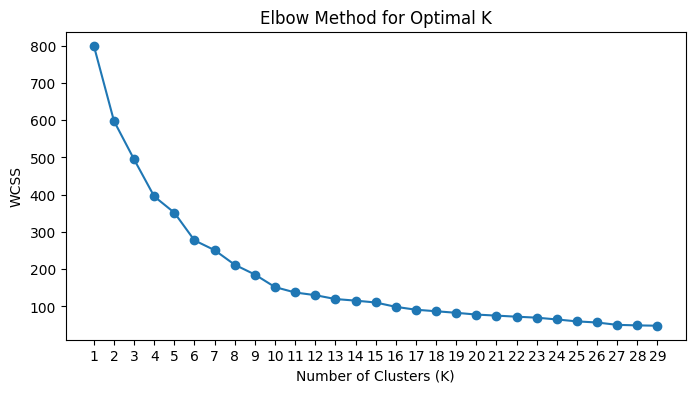

In [10]:
wcss = []
k_range = range(1, 30)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)


plt.figure(figsize=(8,4))
plt.xticks(k_range)
plt.plot(k_range, wcss, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS")
plt.show()

In [11]:
optimal_k = 11

From the elbow graph, a clear bend can be seen at K = 11. After this point, the decrease in WCSS becomes small. So, K = 11 is selected as the optimal number of clusters.

# Applying K-Means

In [12]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)

# Applying DBSCAN

In [13]:
eps_values = range(1, 201)
min_samples_values = range(2, 20)

results = []

for eps_int in eps_values:
    eps = eps_int / 10

    for min_samples in min_samples_values:

        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(scaled_data)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        if n_clusters > 1:
            score = silhouette_score(scaled_data, labels)
        else:
            score = -1

        results.append({
            "eps": eps,
            "min_samples": min_samples,
            "clusters": n_clusters,
            "noise_points": n_noise,
            "silhouette": score
        })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(
    by=["silhouette","noise_points","min_samples","eps"],
    ascending=[False, False,True, True]
)

print(results_df.head(10))

     eps  min_samples  clusters  noise_points  silhouette
180  1.1            2         2             0    0.277604
198  1.2            2         2             0    0.277604
216  1.3            2         2             0    0.277604
234  1.4            2         2             0    0.277604
252  1.5            2         2             0    0.277604
270  1.6            2         2             0    0.277604
288  1.7            2         2             0    0.277604
306  1.8            2         2             0    0.277604
324  1.9            2         2             0    0.277604
342  2.0            2         2             0    0.277604


In [14]:
dbscan = DBSCAN(eps=1.1, min_samples=2)
dbscan_labels = dbscan.fit_predict(scaled_data)

determining optimal eps and min_samples for DBSAN via bruteforce and applying DBSCAN to the dataset

# Applying GMM

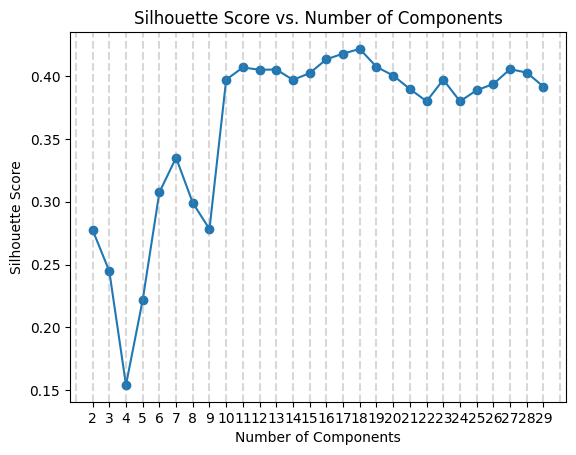

In [15]:
sil_scores = []
components = range(2, 30)
for k in components:
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels = gmm.fit_predict(scaled_data)
    if len(set(labels)) > 1:
        sil_scores.append(silhouette_score(scaled_data, labels))
    else:
        sil_scores.append(-1)

plt.plot(components, sil_scores, marker='o')
plt.xticks(components)

for x in range(1, 31):
    plt.axvline(x=x, color='gray', linestyle='--', alpha=0.3)
plt.title("Silhouette Score vs. Number of Components")
plt.xlabel("Number of Components")
plt.ylabel("Silhouette Score")
plt.show()

In [16]:
optimal_n_components=18

In [17]:
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
gmm_labels = gmm.fit_predict(scaled_data)

Applying GMM after determining optimal n_components via bruteforce

# Evaluation

In [18]:
def evaluate(data, labels, name):
    if len(set(labels)) > 1:
        sil = silhouette_score(data, labels)
        dbi = davies_bouldin_score(data, labels)
        print(f"{name}")
        print(f"  Silhouette Score: {sil:.3f}")
        print(f"  Davies-Bouldin Index: {dbi:.3f}\n")
    else:
        print(f"{name}: Cannot compute metrics\n")

evaluate(scaled_data, kmeans_labels, "KMeans")
evaluate(scaled_data, dbscan_labels, "DBSCAN")
evaluate(scaled_data, gmm_labels, "GMM")

KMeans
  Silhouette Score: 0.428
  Davies-Bouldin Index: 0.842

DBSCAN
  Silhouette Score: 0.278
  Davies-Bouldin Index: 1.612

GMM
  Silhouette Score: 0.407
  Davies-Bouldin Index: 0.885



# Applying PCA for visualization

In [19]:
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(scaled_data)

pca_df = pd.DataFrame({
    "PCA1": pca_result[:,0],
    "PCA2": pca_result[:,1],
    "KMeans": kmeans_labels,
    "DBSCAN": dbscan_labels,
    "GMM": gmm_labels
})

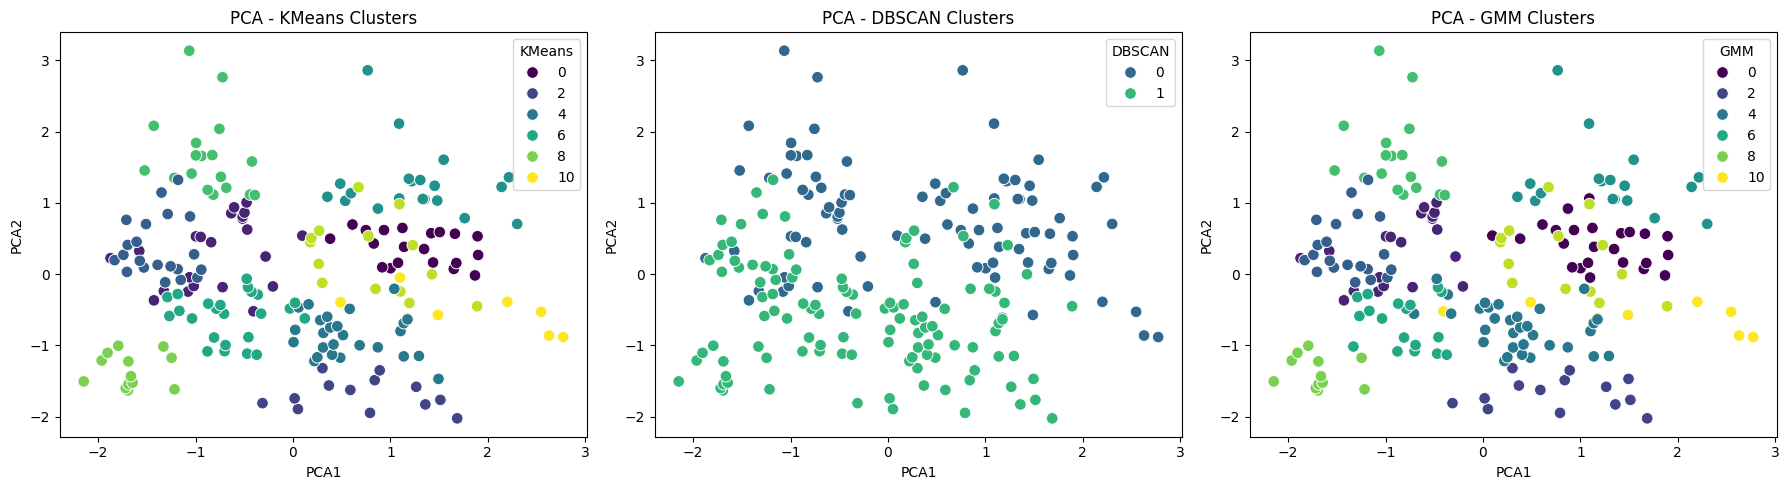

In [20]:
plt.figure(figsize=(18,5))

# KMeans
plt.subplot(1,3,1)
sns.scatterplot(data=pca_df, x="PCA1", y="PCA2",
                hue="KMeans", palette="viridis", s=70)
plt.title("PCA - KMeans Clusters")

# DBSCAN
plt.subplot(1,3,2)
sns.scatterplot(data=pca_df, x="PCA1", y="PCA2",
                hue="DBSCAN", palette="viridis", s=70)
plt.title("PCA - DBSCAN Clusters")

# GMM
plt.subplot(1,3,3)
sns.scatterplot(data=pca_df, x="PCA1", y="PCA2",
                hue="GMM", palette="viridis", s=70)
plt.title("PCA - GMM Clusters")

plt.tight_layout()
plt.show()